<a href="https://colab.research.google.com/github/eddson90/tareas_data_science/blob/main/statistical-learning-2/proyecto-final/parte1/Parte1_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parte 1:  Red Neuronal Feed Forward (FFNN)**

## Proyecto Final: Implementación de Modelos de Deep Learning
---

Statistical Learning II

Universidad Galileo

Eddson Sierra

## Descripción

En esta parte se ha elegido implementar una red neuronal feed forward para modelar el *churn* de un banco. El objetivo es predecir el número de clientes que abandonan el banco. Se trata de un problema de **clasificación** y se trabajará con un dataset estructurado que incluye la columna 'Exited' que indica 1 si el cliente abandonó y 0 de lo contrario.

## Carga inicial de librerías

In [2]:
import pandas as pd
import numpy as np
import time

## Carga de datos

**Créditos del autor del dataset**

El dataset fue tomado del repositorio de Github de Siddharth Dixit. (https://github.com/Sid-darthvader)

In [3]:
url = 'https://raw.githubusercontent.com/Sid-darthvader/Artificial-Neural-Network-on-Churn-Modeling-Dataset-for-a-Bank/master/Churn_Modelling.csv'
data = pd.read_csv(url,sep=',',error_bad_lines=False)

In [4]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Preparación de datos

Podemos observar que las columnas 'RowNumber', y 'Surname' no tienen impacto en el churn por lo que podemos removerlas del dataset.

In [5]:
data = data.drop(['RowNumber','Surname','CustomerId'], axis = 1)

Ahora separamos el dataset en un dataset de etiquetas (Y) y uno de características (X):

In [6]:
X = data.iloc[:,0:10]
X.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58


In [7]:
Y = pd.DataFrame(data.iloc[:,-1].values, columns = ['Exited'])
Y.head(2)

,Exited
0,1
1,0


### Tratamiento de variables categóricas

Observamos que la variable Geography solo tiene 3 posibles valores, y la variable Gender 2 (es mejor verificar). 

In [8]:
np.unique(X['Geography'])

array(['France', 'Germany', 'Spain'], dtype=object)

In [9]:
np.unique(X['Gender'])

array(['Female', 'Male'], dtype=object)

Ejecutamos One Hot Encoding sobre ambas variables y generamos el nuevo dataset X:

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
OHE = OneHotEncoder(dtype='int')
OHE_gen = pd.DataFrame(OHE.fit_transform(X[['Gender']]).toarray(), columns = ['Female','Male'])
OHE_geo = pd.DataFrame(OHE.fit_transform(X[['Geography']]).toarray(), columns = ['France','Germany','Spain'])

In [12]:
X = X.join(OHE_gen)
X = X.join(OHE_geo)

In [13]:
X.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Female,Male,France,Germany,Spain
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,1,0,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,1,0,0,0,1


Removemos las columnas de referencia:

In [14]:
X = X.drop(['Gender','Geography'], axis = 1)
X.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Female,Male,France,Germany,Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,1,0,0,0,1


### Separación de datos

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.80, random_state = 2021)

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.9, random_state = 2021)

In [18]:
print("X Rows: x_train= {}, x_test= {}, x_val= {}".format(x_train.shape[0], x_test.shape[0], x_val.shape[0]))

X Rows: x_train= 7200, x_test= 2000, x_val= 800


In [19]:
print("Y Rows: y_train= {}, y_test= {}, y_val= {}".format(y_train.shape[0], y_test.shape[0], y_val.shape[0])) 

Y Rows: y_train= 7200, y_test= 2000, y_val= 800


### Scaling de datos

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

## Red neuronal feed forward (FFNN)

#### Importar Tensorflow y Keras

In [23]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras import metrics
from keras.layers import BatchNormalization

### Definición de la arquitectura

In [24]:
initializer = tf.keras.initializers.GlorotNormal()

ffnn = Sequential([Flatten(), 
                   Dense(units=512, activation='relu', kernel_initializer=initializer),
                   BatchNormalization(),
                   Dense(units=256, activation='relu',kernel_initializer=initializer),
                   BatchNormalization(),
                   Dense(units=1, activation='sigmoid'),
])

### Parámetros de optimización

In [26]:
ffnn.compile(optimizer = 'adam', 
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), 
            metrics = ['accuracy',
                       tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

### Entrenamiento, validación y evaluación

Creamos una función que entrena la red neuronal de acuerdo a los parámetros epochs, step_per_epoch, batch_size; luego valida los resultados en el dataset de validación, guarda el modelo en un directorio y finalmente evalúa la red en los datos de prueba devolviendo un dataframe con el nombre del modelo y los resultados de las métricas en el dataset de pruebas.

Internamente, la función también crea un checkpoint de los mejores steps del modelo y los guarda en un directorio a través de un callback. 

In [27]:
def train_val(epochs, steps_per_epoch, batch_size, verbose):
  # Definición de Callbacks
  model_checkpoint =  tf.keras.callbacks.ModelCheckpoint(
      filepath = '/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte1_FFNN/Checkpoints/checkpoint_e-{epoch:02d}_-val_acc-{val_accuracy:.2f}.h5',
      save_weights_only=False,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True,
      save_freq='epoch',
      verbose=verbose)
  
  myCallbacks = [model_checkpoint]

  # Entrenamiento y validación de la red
  ffnn.fit(x_train, y_train, 
          epochs=epochs,
          batch_size = batch_size,
          steps_per_epoch=steps_per_epoch,
          validation_data = (x_val, y_val),
          verbose = verbose,
          callbacks=myCallbacks
          )

  # Guardar el modelo con el timestamp de ejecución
  timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time()))
  ffnn.save('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte1_FFNN/Models/ffnn_'+str(timestamp)+'_bs='+str(batch_size)+'.h5')

  # Generar dataframe con métricas de evaluación del modelo
  model_name = 'ffnn_'+str(timestamp)+'_bs='+str(batch_size)+'_ep='+str(epochs)+'_spe='+str(steps_per_epoch)

  bitacora = pd.DataFrame(np.hstack((model_name,np.array(ffnn.evaluate(x_test, y_test, verbose=0)))).reshape(1,6), 
                          columns = ['name','loss','accuracy','binary_accuracy','precision','recall'])
  
  bitacora['f1_score'] = 2*(float(bitacora['precision'])*float(bitacora['recall']))/(float(bitacora['precision'])+float(bitacora['recall']))

  return bitacora

In [28]:
train_val(epochs=5, steps_per_epoch=5, batch_size=2, verbose=1)

Epoch 1/5
5/5 [==============================] - 6s 375ms/step - loss: 1.0815 - accuracy: 0.5000 - binary_accuracy: 0.5000 - precision: 0.2000 - recall: 0.5000 - val_loss: 0.6652 - val_accuracy: 0.6275 - val_binary_accuracy: 0.6275 - val_precision: 0.2625 - val_recall: 0.5097

Epoch 00001: val_accuracy improved from -inf to 0.62750, saving model to /content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte1_FFNN/Checkpoints/checkpoint_e-01_-val_acc-0.63.h5
Epoch 2/5
5/5 [==============================] - 1s 272ms/step - loss: 0.4952 - accuracy: 0.8000 - binary_accuracy: 0.8000 - precision: 0.6000 - recall: 1.0000 - val_loss: 0.6527 - val_accuracy: 0.6288 - val_binary_accuracy: 0.6288 - val_precision: 0.2861 - val_recall: 0.6129

Epoch 00002: val_accuracy improved from 0.62750 to 0.62875, saving model to /content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte1_FFNN/Checkpoints/checkpoint_e-02_-val_acc-0.63.h5
Epoch 3/5
5/5 [==============================] - 1s 326ms/step - 

,name,loss,accuracy,binary_accuracy,precision,recall,f1_score
0,ffnn_20210923_215115_bs=2_ep=5_spe=5,0.6474273800849915,0.6119999885559082,0.6119999885559082,0.22900763154029846,0.35629454255104065,0.27881


Entrenamos varios modelos (5 experimentos):

In [29]:
ffnn1 = train_val(epochs=100, steps_per_epoch=20, batch_size=2, verbose=0)
ffnn2 = train_val(epochs=100, steps_per_epoch=40, batch_size=4, verbose=0)
ffnn3 = train_val(epochs=100, steps_per_epoch=60, batch_size=32, verbose=0)
ffnn4 = train_val(epochs=100, steps_per_epoch=20, batch_size=16, verbose=0)
ffnn5 = train_val(epochs=100, steps_per_epoch=40, batch_size=2, verbose=0)

Concatenamos todos los resultados para poder compararlos en un dataframe final:

In [30]:
resumen = pd.concat([ffnn1,ffnn2, ffnn3, ffnn4, ffnn5], ignore_index = True)
resumen

,name,loss,accuracy,binary_accuracy,precision,recall,f1_score
0,ffnn_20210923_215412_bs=2_ep=100_spe=20,0.565550684928894,0.7680000066757202,0.7680000066757202,0.45057472586631775,0.4655582010746002,0.457944
1,ffnn_20210923_215635_bs=4_ep=100_spe=40,0.4121256172657013,0.828000009059906,0.828000009059906,0.6711111068725586,0.35866984724998474,0.467492
2,ffnn_20210923_215724_bs=32_ep=100_spe=60,0.37255480885505676,0.847000002861023,0.847000002861023,0.6619718074798584,0.5581947565078735,0.605670
3,ffnn_20210923_215805_bs=16_ep=100_spe=20,0.3760450780391693,0.8554999828338623,0.8554999828338623,0.7598425149917603,0.45843231678009033,0.571852
4,ffnn_20210923_220027_bs=2_ep=100_spe=40,1.1485934257507324,0.8209999799728394,0.8209999799728394,0.931506872177124,0.16152018308639526,0.275304


### Selección

También es posible y más recomendable en caso de modelos que toman más tiempo en el entrenamiento, cargar los modelos entrenados y evaluarlos a continuación.

Cargamos los modelos (deployment):

In [31]:
exp1 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte1_FFNN/Models/ffnn_20210923_215412_bs=2.h5')
exp2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte1_FFNN/Models/ffnn_20210923_215635_bs=4.h5')
exp3 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte1_FFNN/Models/ffnn_20210923_215724_bs=32.h5')
exp4 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte1_FFNN/Models/ffnn_20210923_215805_bs=16.h5')
exp5 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte1_FFNN/Models/ffnn_20210923_220027_bs=2.h5')

Y los evaluamos en el dataset de pruebas:

In [32]:
met1 = pd.DataFrame(np.array(exp1.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met2 = pd.DataFrame(np.array(exp2.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met3 = pd.DataFrame(np.array(exp3.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met4 = pd.DataFrame(np.array(exp4.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met5 = pd.DataFrame(np.array(exp5.evaluate(x_test,y_test, verbose=0)).reshape(1,5))

Obtenemos las métricas y las almacenamos en un dataframe:

In [42]:
metricas = pd.concat([met1,met2,met3,met4,met5], ignore_index=True)
metricas.columns = ['loss','accuracy','binary_accuracy','precision','recall']
metricas['f1_score'] = (2.0*metricas['precision']*metricas['recall'])/(metricas['precision']+metricas['recall'])
metricas

,loss,accuracy,binary_accuracy,precision,recall,f1_score
0,0.565551,0.7680,0.7680,0.450575,0.465558,0.457944
1,0.412126,0.8280,0.8280,0.671111,0.358670,0.467492
2,0.372555,0.8470,0.8470,0.661972,0.558195,0.605670
3,0.376045,0.8555,0.8555,0.759843,0.458432,0.571852
4,1.148593,0.8210,0.8210,0.931507,0.161520,0.275304


El mejor modelo corresponde al experimento 4 entrenando la red neuronal con 100 epochs, 20 pasos por epoch y un batch size de 16.

## Anexos

Captura de pantalla de los checkpoints generados y guardados:

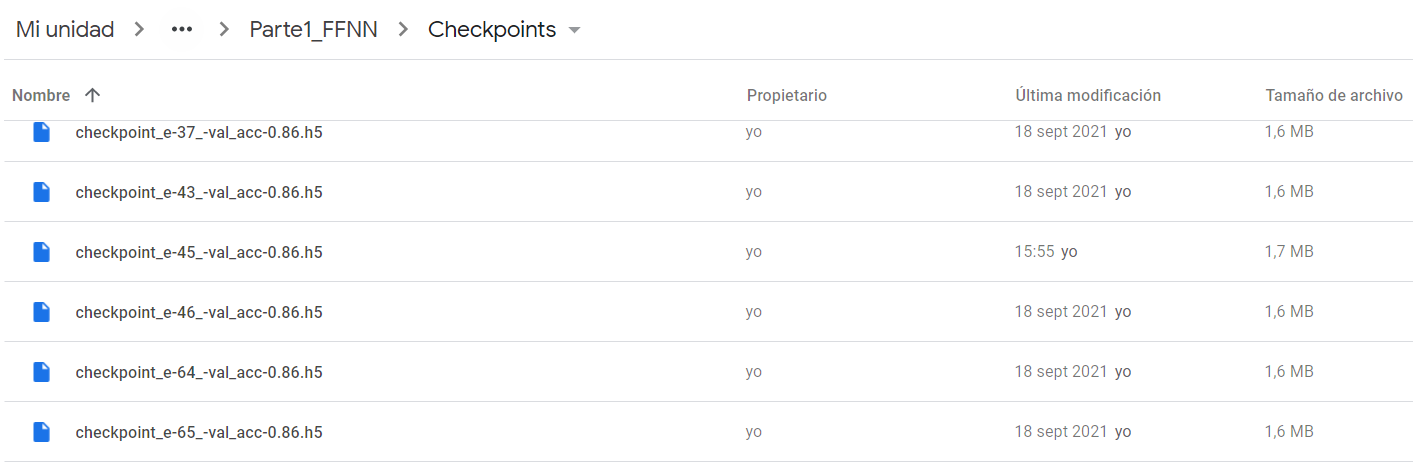